## Data Preparation
Let's load this data into Python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('users.csv',  encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

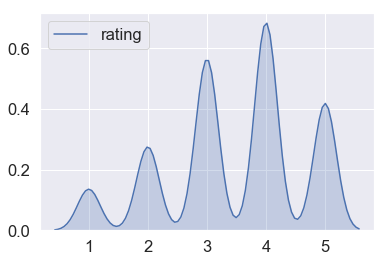

In [2]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
#sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))
sns.kdeplot(ratings['rating'].fillna(ratings['rating'].median()), shade=True);

## Content-Based Recommendation Model

Computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

In [3]:
listGen = []
movies['genres'].fillna("").astype('str')
for movie in movies['genres'].values:
    if pd.isnull(movie):
        continue
    items = movie.split('|')
    for item in items:
        if item not in listGen:
            listGen.append(item)

print(listGen)

['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical']


In [4]:
Ij = []

for movie in movies['genres'].values:
    rows = []
    
    for j, item in enumerate(listGen):
        if pd.isnull(movie):
            rows.append(0)
            continue
        if item in movie.split('|'):
            rows.append(1)
        else:
            rows.append(0)
    Ij.append(rows)
print(Ij[:4])

[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]


In [5]:
dataset = pd.merge(ratings, movies)
dataset= dataset.groupby('user_id')['genres'].apply(list)
Uj = []
for row in dataset:
    rows = []
    
    for j, item in enumerate(listGen):
        if item in row:
            rows.append(1)
        else:
            rows.append(0)
    Uj.append(rows)
    
print(Uj[:4])

[[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]]


In [6]:
print(Ij[50])
print(Uj[50])
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(Uj,Ij)
print(cos_sim)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[[0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]
 [0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]
 [0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]
 ...
 [0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]
 [0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]
 [0.23570226 0.         0.57735027 ... 0.57735027 0.40824829 0.57735027]]


## Collaborative Filtering Recommendation Model


Use the file **ratings.csv** first as it contains User ID, Movie IDs and Ratings. These three elements are all needed for determining the similarity of the users based on their ratings for a particular movie.


In [7]:
import math
def correlation_similarity(v1,v2):
    v1 = v1 - np.nanmean(v1)
    v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if np.isnan(x) or np.isnan(y) or x == 0 or y ==0: continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxx == 0 and sumyy == 0:
        sumxx = sumyy = 1
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]
    print(N)
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = correlation_similarity(v1,v2)
    print(sim.shape)
    return sim

In [8]:
# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [9]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.5)
print(test_data.head())

      user_id  movie_id  rating
1883       26         2       2
6071       81        84       3
6787       91        17       4
2400       32        96       4
1179       16        37       4


In [10]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.pivot_table(index='movie_id', columns='user_id', values='rating').astype('float64')
test_data_matrix = test_data.pivot_table(index='movie_id', columns='user_id', values='rating').astype('float64')
print(test_data_matrix)

user_id   1    2    3    4    5    6    7    8    9    10  ...   91   92   \
movie_id                                                   ...              
1         3.0  3.0  3.0  1.0  NaN  NaN  NaN  NaN  4.0  NaN ...   NaN  NaN   
2         NaN  4.0  NaN  3.0  4.0  NaN  NaN  1.0  NaN  NaN ...   4.0  NaN   
3         NaN  NaN  4.0  3.0  NaN  4.0  4.0  3.0  5.0  3.0 ...   4.0  NaN   
4         NaN  NaN  3.0  NaN  4.0  NaN  NaN  NaN  5.0  4.0 ...   NaN  NaN   
5         NaN  NaN  3.0  3.0  NaN  NaN  2.0  NaN  NaN  NaN ...   1.0  5.0   
6         3.0  NaN  NaN  NaN  NaN  3.0  NaN  5.0  NaN  4.0 ...   NaN  NaN   
7         NaN  NaN  3.0  NaN  NaN  4.0  5.0  3.0  2.0  NaN ...   NaN  NaN   
8         NaN  4.0  4.0  3.0  NaN  4.0  5.0  NaN  NaN  NaN ...   NaN  NaN   
9         NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  3.0  NaN ...   4.0  3.0   
10        NaN  NaN  3.0  5.0  NaN  NaN  NaN  NaN  3.0  NaN ...   5.0  NaN   
11        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN   

In [11]:
user_correlation = sim_matrix(train_data_matrix.values)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

100
(100, 100)
[[ 0.          0.07137971  0.38859816 ... -0.28850821 -0.11249405
   0.08034832]
 [ 0.07137971  0.          0.0921908  ... -0.21308849  0.18955068
  -0.68453186]
 [ 0.38859816  0.0921908   0.         ... -0.19515261  0.16240475
  -0.34494371]
 ...
 [-0.28850821 -0.21308849 -0.19515261 ...  0.         -0.01886325
   0.65996591]
 [-0.11249405  0.18955068  0.16240475 ... -0.01886325  0.
  -0.00765929]
 [ 0.08034832 -0.68453186 -0.34494371 ...  0.65996591 -0.00765929
   0.        ]]
(100, 100)


In [12]:
# Item Similarity Matrix
item_correlation = sim_matrix(train_data_matrix.values, 'item')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)
print(item_correlation.shape)

100
(100, 100)
[[ 0.          0.2368592  -0.36467684 ...  0.21026521 -0.10886378
   0.57142049]
 [ 0.2368592   0.         -0.15068957 ...  0.45896228 -0.1981424
  -0.00936389]
 [-0.36467684 -0.15068957  0.         ...  0.21438342 -0.05621336
   0.01630203]
 ...
 [ 0.21026521  0.45896228  0.21438342 ...  0.         -0.45603076
   0.11844223]
 [-0.10886378 -0.1981424  -0.05621336 ... -0.45603076  0.
  -0.01087008]
 [ 0.57142049 -0.00936389  0.01630203 ...  0.11844223 -0.01087008
   0.        ]]
(100, 100)


In [13]:
def user_cf(M, sim_users):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=1)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[i] + np.nansum(sim_users[i] * (M[:,j] - avg_ratings)) / sum(sim_users[i])
    return pred

In [14]:
def item_cf(M, sim_items):
    pred = np.copy(M)
    n_users, n_items = M.shape
    avg_ratings = np.nanmean(M, axis=0)
    for i in range(n_users):
        for j in range(n_items):
            if np.isnan(M[i,j]):
                pred[i,j] = avg_ratings[j] + np.nansum(sim_items[j] * (M[i,:] - avg_ratings)) / sum(sim_items[j])
    return pred

In [15]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        pred = user_cf(ratings, user_correlation)
    elif type == 'item':
        pred = item_cf(ratings, item_correlation)
    return pred

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    return sqrt(np.nanmean(pred - actual)** 2)

In [17]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix.values, user_correlation, type='user')
item_prediction = predict(train_data_matrix.values, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix.values)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix.values)))

User-based CF RMSE: 0.06540660471583047
Item-based CF RMSE: 0.758456699100966
